# Assignment: Unsupervised Machine Learning \ Clustering

### Submitted by: Noa Koter, Nitzan Tal

## Part 1: Partitional Clustering

In this assignment you will experience with partitional & mixture model clustering. The analyses are made on real datasets under the circumstances of real life challenges in unsupervised machine learning.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

### Read blood test results as an EMR from an Excel file

In [2]:
# Open the file and # Get the first sheet as an object
sheet1 = pd.read_excel('EMR-Blood.xlsx',engine='openpyxl')

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows
sheet1[:10]

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Use K-Means to create clusters according to variables of uniform distribution

In [3]:
# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

# Run the K-Means algorithm, assuming the correct number of clusters is 5
kmeans_classifier = KMeans(5)
y_pred_KMeans1 = kmeans_classifier.fit_predict(EMR3d1)

### Make a 3D chart

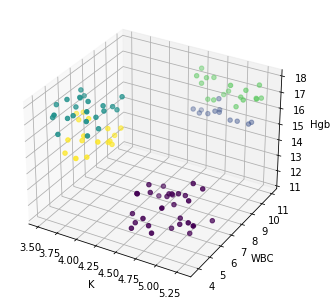

In [4]:
def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred)

make_chart(EMR3d1, y_pred_KMeans1, variables1)

## Challenge 210
Implement  Lloyd's Algorithm for solving the K-Means problem, as shown in class.
By examining the WCSS, choose a proper threshold to determine algorithm convergence.

Compare your results to the _sklearn_ version - what can affect any differences you might've got?

In [5]:
# Add your code for Challenge 210 after this line, and keep it in this cell.

from sklearn.metrics.pairwise import euclidean_distances

EPSILON = 1e-10  # convergence threshold (change in WCSS)
MAX_ITERATIONS = 50 # in case of bad initialization

class KMeansClassifier:

    def __init__(self, k, X = None, kmeans_pp_init = True, plot_progrees = False):
        self.k = k
        self.cluster_centers = []
        self.labels = []
        self.X = X
        self.kmeans_pp_init = kmeans_pp_init
        self.plot_progrees = plot_progrees


    def fit(self, X, iteration = 0):
        ''' Fit the classifier on the data X '''
        
        if X is not None:
            self.X = X

        # initialize
        self.initialize_cluster_centers()
        wcss_is_improving = True
        prev_wcss = 9999

        while wcss_is_improving: # should be changes to a threshold of change in centroids
            self.assign_clusters()
            self.update_cluster_centers()
            
            if self.plot_progrees:
                self.plot()
            
            current_wcss = self.calculate_wcss()
            improvement = prev_wcss - current_wcss
            if improvement < EPSILON:
                wcss_is_improving = False
            else:
                prev_wcss = current_wcss

        # if we have one or more cluster centers without any points - try another initialization
        if len(np.unique(self.labels)) == self.k or iteration >= MAX_ITERATIONS:
            return self
        else:
            return self.fit(X, iteration + 1)

        
    def predict(self, X_pred = None):
        ''' Predict clustering for X_pred. assumed the classifier was fit before '''

        if X_pred is not None:
            euclidean_matrix = np.sqrt(
                np.sum((np.expand_dims(self.cluster_centers, 1) - np.expand_dims(X_pred, 0)) ** 2, axis=-1))
            return np.argmin(euclidean_matrix, axis=0)
        else:
            return self.labels


    def fit_predict(self, X):
        ''' fit the classifier on X and return its prediction on X '''


        return self.fit(X).predict()


    def assign_clusters(self):
        ''' for every datapoint, assign it to the closest cluster centroid '''

        euclidean_matrix = np.sqrt(np.sum((np.expand_dims(self.cluster_centers, 1) - np.expand_dims(self.X, 0)) ** 2, axis=-1))
        self.labels = np.argmin(euclidean_matrix, axis=0)

        
    def initialize_cluster_centers(self):
        ''' Initialize the clusters centers (random init or KMenas++) '''

        # KMeans++ init
        if self.kmeans_pp_init is True:
            random_index = np.random.randint(self.X.shape[0])
            self.cluster_centers.append(self.X[random_index].tolist())

            for i in np.arange(self.k - 1):
                euclidean_matrix = euclidean_distances(self.cluster_centers, self.X)
                distance_to_nearest_center = np.min(euclidean_matrix, axis = 0)
                furthest_point = np.argmax(distance_to_nearest_center, axis=-1)
                self.cluster_centers.append(self.X[furthest_point].tolist())

            self.cluster_centers = np.array(self.cluster_centers)

        else:   # random init (choose points from the data, like sklearn)            
            k_random_indices = np.random.choice(range(self.X.shape[0]), size = self.k, replace=False)
            self.cluster_centers = self.X[k_random_indices]
            

    def update_cluster_centers(self):
        ''' Update each cluster center with the mean of its points '''
        
        for cluster_idx in range(self.k):
            cluster_points = self.labels == cluster_idx
            if np.sum(cluster_points) > 0:  # only update is there are points assigned to this cluster
                new_center = np.mean(self.X[cluster_points, :], axis=0)
                self.cluster_centers[cluster_idx] = new_center


    # for debugging, works up to 10 clusters
    def plot(self):
        ''' plot the clusters and their centers'''
        
        centroids = self.cluster_centers
        X = self.X

        # scatter plot, dots colored by class value
        df = pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=self.labels))
        colors = {0: 'red', 1: 'cyan', 2: 'pink', 3: 'orange', 4: 'yellow', 5: 'magenta', 6: 'purple', 7: 'orange', 
                  8: 'green', 9: 'blue'}
        fig, ax = plt.subplots()

        grouped = df.groupby('label')

        for key, group in grouped:
            group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

        ax.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
        plt.show()


    def calculate_bcss(self):
        ''' calculate Between Clusters Sum of Squares'''
        
        x_bar = np.mean(self.X, axis = 0)
        euclidean_matrix = np.sqrt(np.sum((np.expand_dims(self.cluster_centers, 1) - \
                                           np.expand_dims(x_bar, 0)) ** 2, axis=-1))
        
        _, num_of_points_in_cluster = np.unique(self.labels, return_counts=True)
        bcss = 0
        for cluster_idx in range(self.k):
            bcss += np.sum(num_of_points_in_cluster[cluster_idx] * (self.cluster_centers[cluster_idx] - x_bar) ** 2)

        return bcss


    def calculate_wcss(self):
        ''' calculate Within Cluster Sum of Squares '''

        wcss = 0
        for cluster_idx in np.arange(self.k):
            cluster_data = self.X[self.labels == cluster_idx]
            if len(cluster_data) > 0:  # points in cluster

                squared_distance_of_data_from_center = (self.cluster_centers[cluster_idx] - \
                                                   np.expand_dims(cluster_data, 0)) ** 2
                wcss += np.sum(squared_distance_of_data_from_center)

        return wcss
    
    
    def mean_dist_from_points_in_other_cluster(self, X, X_other):
        ''' calculate mean distance between all points in one cluster to all points in another cluster '''
        
        points_in_other_cluster = X_other.shape[0]      
        distance_between_points = euclidean_distances(X, X_other)
        mean_distance_per_point = np.sum(distance_between_points, axis = 1) / points_in_other_cluster
        
        return mean_distance_per_point


    def calculate_silhouette(self):
        ''' calculate Silhouette samples and average Silouhette score ''' 

        silhouette_score = 0
        sil_samples_list = {}
        for cluster_idx in np.arange(self.k):
            mean_dist_vec_list  = []
            cluster_points = self.labels == cluster_idx
            points_in_cluster = np.sum(cluster_points)
            if  points_in_cluster > 1: 
                distance_between_points_in_cluster = euclidean_distances(self.X[cluster_points], self.X[cluster_points])
                distance_sum_per_point = np.sum(distance_between_points_in_cluster, axis = 1)
                a_vec = distance_sum_per_point / (points_in_cluster - 1)
                
                for other_cluster in np.arange(self.k):
                    if other_cluster != cluster_idx:
                        other_cluster_points = self.labels == other_cluster
                        num_of_other_cluster_points = np.sum(other_cluster_points)
                        if num_of_other_cluster_points > 0:
                            mean_dist = self.mean_dist_from_points_in_other_cluster(self.X[cluster_points], self.X[other_cluster_points])
                            mean_dist_vec_list.append(mean_dist)
                        else: # no points in the other cluster
                            pass

                dist_matrix = np.matrix(mean_dist_vec_list)
                b_vec = np.array(np.min(dist_matrix, axis = 0))
                a_vec = np.expand_dims(a_vec, axis = 0)
        
                a_b = np.concatenate((a_vec, b_vec), axis=0)
                max_vec = np.max(a_b, axis = 0)
                s_vec = (b_vec - a_vec) / max_vec
                
                sil_samples_list[cluster_idx] = s_vec
            else:
                sil_samples_list[cluster_idx] = [0]
        
        for k, v in sil_samples_list.items():
            silhouette_score += np.sum(v)
            
        silhouette_score = silhouette_score / self.X.shape[0]
    
        return sil_samples_list, silhouette_score 
        

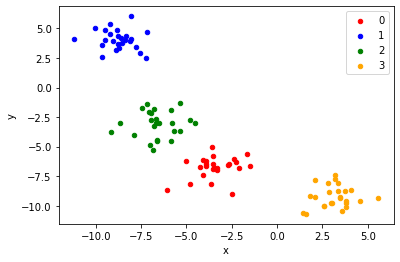

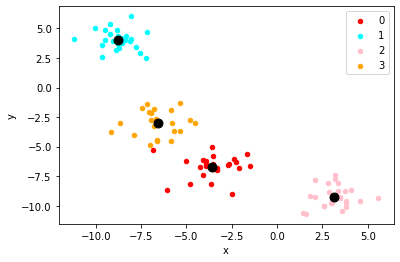

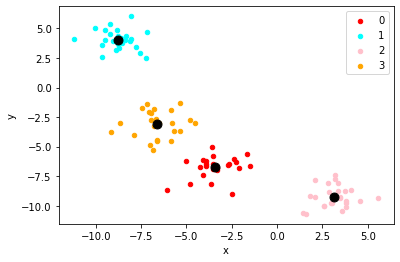

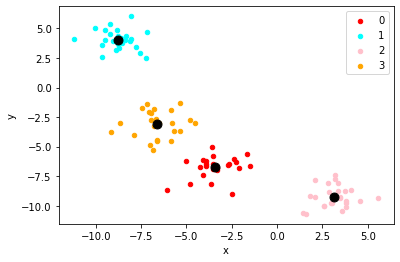

wcss =  181.57081615586614
bcss =  4534.669899547167


In [6]:
# test classifier (with visualization)

from sklearn.datasets import make_blobs
CLUSTERS = 4

def test_kmeans():
    # generate 2d classification dataset
    X, y = make_blobs(n_samples=100, centers=CLUSTERS, n_features=2)
    # scatter plot, dots colored by class value
    df = pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=y))
    colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'yellow'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()

    kmeans_classifier = KMeansClassifier(CLUSTERS, True, plot_progrees = True)
    kmeans_classifier.fit(X).predict()
    
    print('wcss = ', kmeans_classifier.calculate_wcss())
    print('bcss = ', kmeans_classifier.calculate_bcss())
    
test_kmeans()

### Compare your results to the _sklearn_ version 

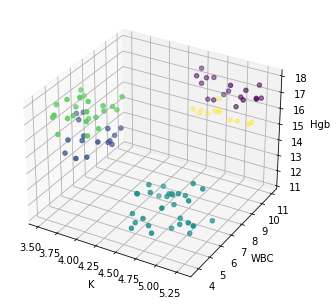

In [19]:
# Using SKlearn

from sklearn.metrics import silhouette_score
CLUSTERS = 5

kmeans_classifier = KMeans(CLUSTERS).fit(EMR3d1)
y_pred_KMeans1 = kmeans_classifier.predict(EMR3d1)
make_chart(EMR3d1, y_pred_KMeans1, variables1)
sklearn_wcss = kmeans_classifier.inertia_

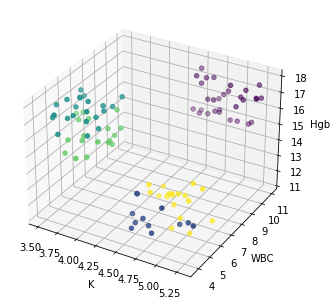

In [20]:
# KMeans using KMeans ++ initialization
our_classifier_kmeans_pp  = KMeansClassifier(CLUSTERS, True)
y_pred_KMeans2 = our_classifier_kmeans_pp.fit_predict(EMR3d1)
make_chart(EMR3d1, y_pred_KMeans2, variables1)

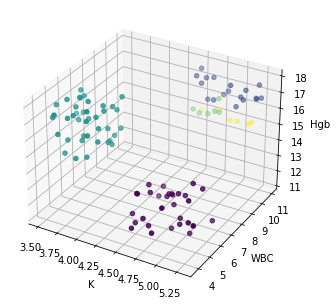

In [21]:
# KMeans using random initialization
our_classifier_rand_init  = KMeansClassifier(CLUSTERS, kmeans_pp_init = False, plot_progrees = False)
y_pred_KMeans_rand_init = our_classifier_rand_init.fit_predict(EMR3d1)
make_chart(EMR3d1, y_pred_KMeans_rand_init, variables1)

In [22]:
# comparison:

print('SKlearn')
print('-------')
print(f'silhouette score = {silhouette_score(EMR3d1, y_pred_KMeans1, metric="euclidean"):.3f}')
print(f'wcss = {sklearn_wcss:.3f}')

print('\nour model using KMeans ++')
print('-------------------------')
_, sil_score_our_kmeans_pp = our_classifier_kmeans_pp.calculate_silhouette()
print(f'silhouette score = {sil_score_our_kmeans_pp:.3f}')
print('wcss = ', round(our_classifier_kmeans_pp.calculate_wcss(), 5))

print('\nour model using random initialization')
print('-------------------------------------')
_, rand_init_score = our_classifier_rand_init.calculate_silhouette()
print(f'silhouette score = {rand_init_score:.3f}')
print('wcss = ', round(our_classifier_rand_init.calculate_wcss(), 5))

SKlearn
-------
silhouette score = 0.472
wcss = 85.724

our model using KMeans ++
-------------------------
silhouette score = 0.477
wcss =  91.42434

our model using random initialization
-------------------------------------
silhouette score = 0.529
wcss =  110.70349


#### what can affect any differences you might've got?

We've got a silhoutte score and wcss scores that are pretty close to the one of SKLearn KMeans. The different measures change from run to run, but generally SKlearn produces better results. The differences can be affected by the intialization values which are critical for KMeans (This is clear especially when we use random initialization vs Kmeans ++ which is a better way of initialization). In addition, SKlearn runs multiple iterations looking for a better initialization that produces minimal wcss, which is not implmented in our classifier.

## Challenge 211

Humans can clearly spot 3 clusters, however, for machines it's much harder to "learn" that. In the above implementation, K-Means was given the value of 5 as K.
Develop a **generic** mechanism for finding the most reasonable number of clusters by:
1. Iterating K over a reasonable range, which should be derived from the number of points
2. Choose a proper K based on the heuristics learned in class
3. Showing the final clusters in a 3D chart

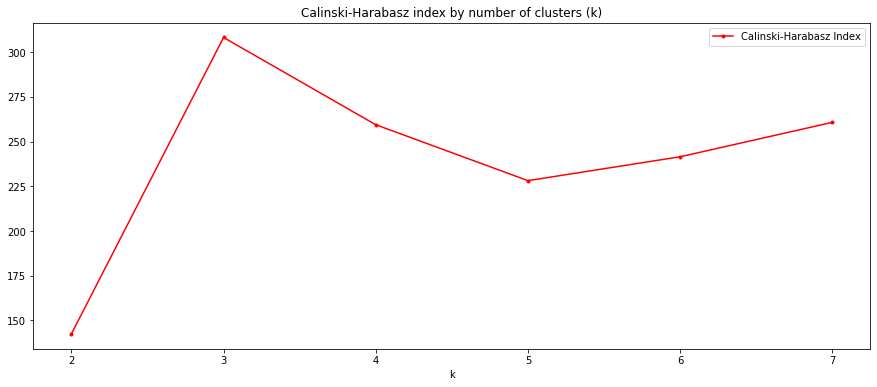

optimal k according to Calinski-Harabasz score is  3
selected k =  3


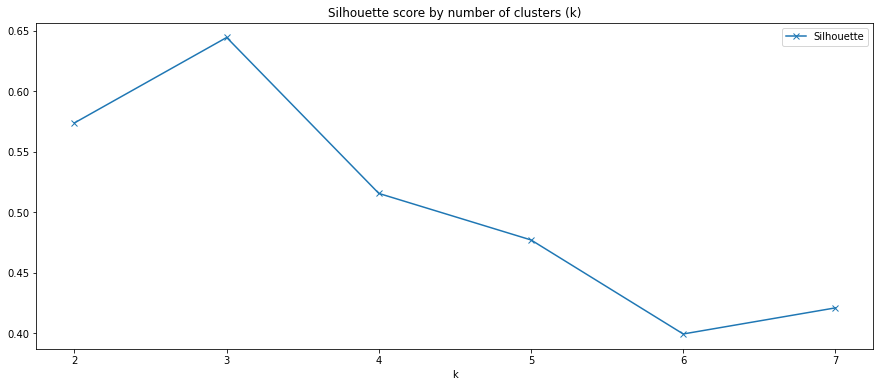

optimal k according do Silhouette score is  3
selected k =  3


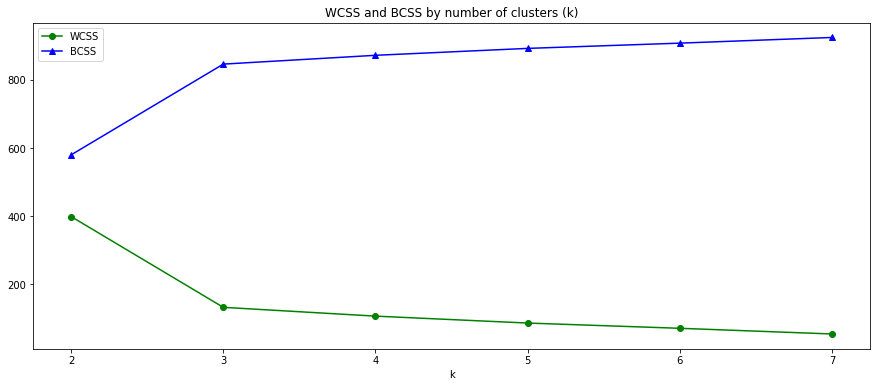

optimal k according do WCSS value is  3
selected k =  3


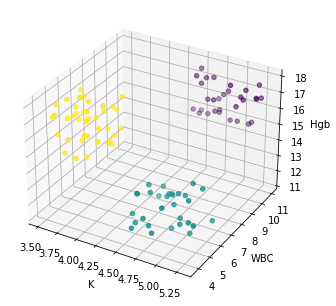

In [11]:
import numpy.matlib

def find_optimal_k(X, method = None, plot = False):
    
    N = X.shape[0]
    wcss_vec , bcss_vec, sil_vec = [], [], []
    ch_index_vec = []
        
    # empirical method of k = sqrt(N/2) so that each cluster contains sqrt(2 * N) points
    
    initial_k = int(np.sqrt(N/2)) 
    #print(initial_k)
    values_of_k = np.arange(2, initial_k + 1)
    
    for k in values_of_k:
        kmeans_classifier = KMeansClassifier(int(k), True)
        kmeans_classifier = kmeans_classifier.fit(EMR3d1)

        wcss = kmeans_classifier.calculate_wcss()
        bcss = kmeans_classifier.calculate_bcss()
        sil_samples, sil_score = kmeans_classifier.calculate_silhouette()
        ch_index = bcss / wcss * ((N - k) / (k - 1))
        
        wcss_vec.append(wcss)
        bcss_vec.append(bcss)
        ch_index_vec.append(ch_index)
        sil_vec.append(sil_score)
        
    if plot:
        fig=plt.figure(figsize=(15,6))
        plt.xlabel('k')
        plt.xticks(values_of_k)


    if method == 'sil':
        if plot:
            plt.title('Silhouette score by number of clusters (k)')
            plt.plot(values_of_k, sil_vec, label="Silhouette", marker = 'x')
            plt.legend()
            plt.show()


        selected_k = values_of_k[np.argmax(sil_vec)]
        print("optimal k according do Silhouette score is ", selected_k)
        return selected_k
    
    if method == 'elbow':
        
        if plot:
            plt.title('WCSS and BCSS by number of clusters (k)')
            plt.plot(values_of_k, wcss_vec, label="WCSS", marker = 'o', c = 'g')
            plt.plot(values_of_k, bcss_vec, label="BCSS", marker = '^', c = 'b')
            plt.legend()
            plt.show()


        all_coordinates = np.vstack((range(len(wcss_vec)), wcss_vec)).T
        np.array([range(len(wcss_vec)), wcss_vec])
        first_point = all_coordinates[0]
        line_vec = all_coordinates[-1] - all_coordinates[0]
        line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
        vec_from_first = all_coordinates - first_point
        scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, len(wcss_vec), 1), axis=1)
        vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
        vec_to_line = vec_from_first - vec_from_first_parallel
        distance_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
        elbow_point_index = np.argmax(distance_to_line)

        selected_k = values_of_k[elbow_point_index]
        print("optimal k according do WCSS value is ", selected_k)
        return selected_k

        
    if method == 'ch':
        
        if plot:
            plt.title('Calinski-Harabasz index by number of clusters (k)')
            plt.plot(values_of_k, ch_index_vec, label="Calinski-Harabasz Index", marker = '.', c = 'r')
            plt.legend()
            plt.show()


        selected_k = values_of_k[np.argmax(ch_index_vec)]
        print("optimal k according to Calinski-Harabasz score is ", selected_k)
        return selected_k
           
        
        
# Run the function with all three methods       

optimal_k = find_optimal_k(EMR3d1, 'ch', plot = True)
print('selected k = ',optimal_k)

optimal_k = find_optimal_k(EMR3d1, 'sil', plot = True)
print('selected k = ',optimal_k)

optimal_k = find_optimal_k(EMR3d1, 'elbow', plot = True)
print('selected k = ', optimal_k)


kmeans_classifier = KMeansClassifier(optimal_k, True)
kmeans_classifier = kmeans_classifier.fit(EMR3d1)
y_pred_KMeans = kmeans_classifier.predict()
make_chart(EMR3d1, y_pred_KMeans, variables1)

### Silhouette analysis

Use graphic visualization of the Silhouette score to support your above answer:

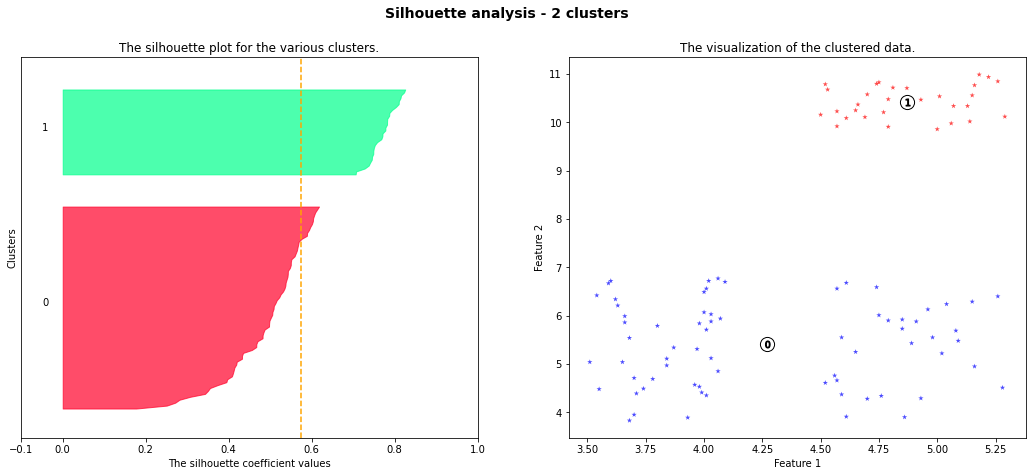

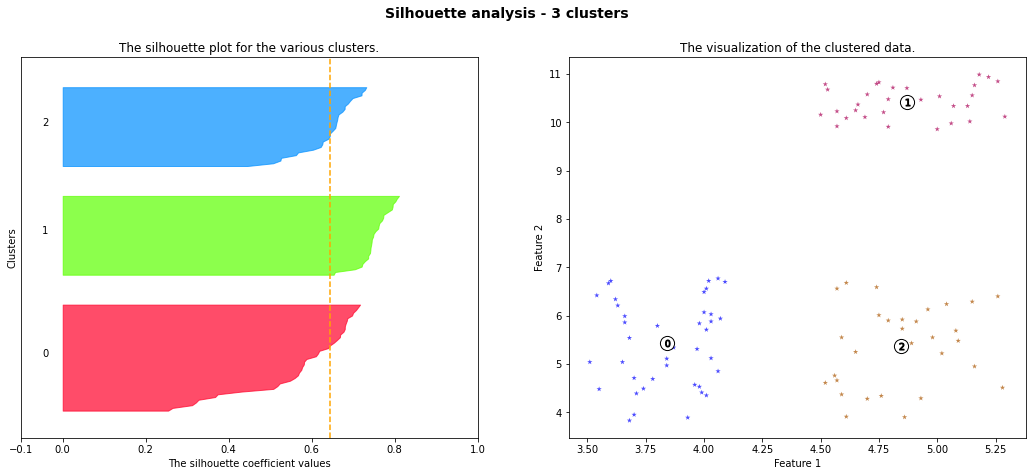

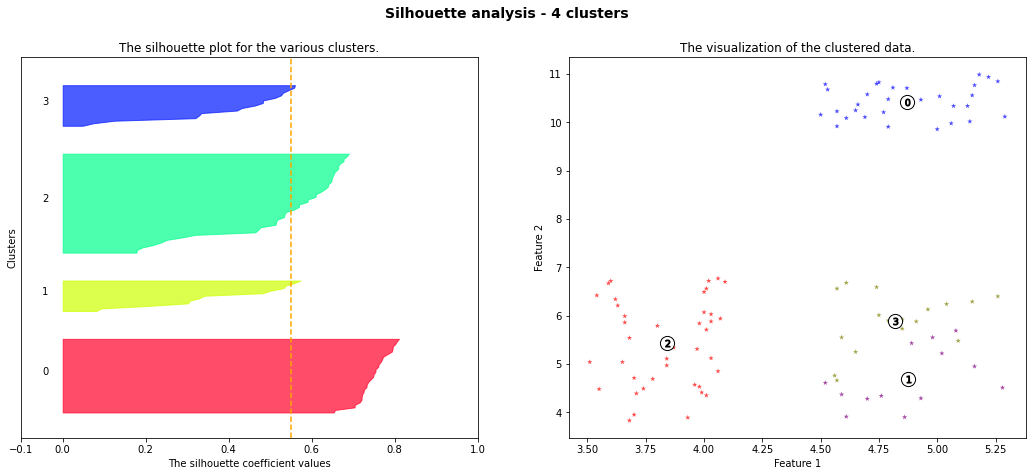

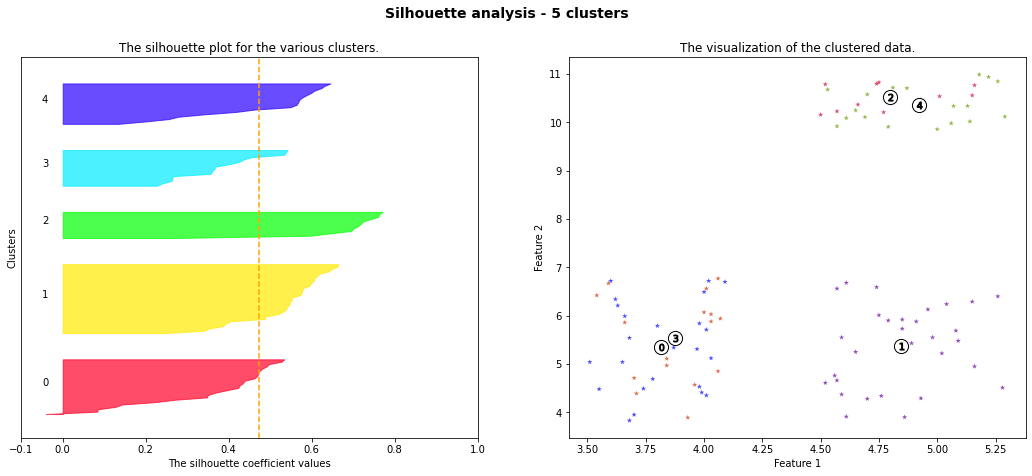

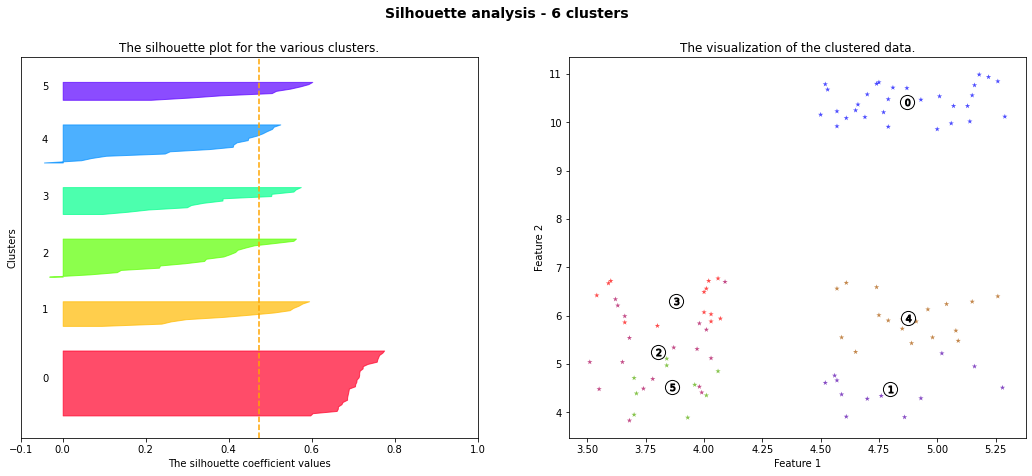

In [12]:
# Add your code for the Sillhouette graphic analysis

import matplotlib.cm as cm

def plot_Silhouette(X, num_clusters):

    for n_clusters in np.arange(2, num_clusters):

        my_classifier = KMeansClassifier(n_clusters, True)
        cluster_labels = my_classifier.fit_predict(X)
        silhouette_samples_dict, silhouette_avg = my_classifier.calculate_silhouette()
                
        fig, (ax1, ax2) = plt.subplots(1, 2)   # Create a subplot with 1 row and 2 columns
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])    # The 1st subplot is the silhouette plot
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        y_lower = 10
        
        for cluster_ind in range(n_clusters):
            samples = silhouette_samples_dict[cluster_ind]
            
            silhouette_values = samples[0, :]
            silhouette_values.sort()
            
            cluster_size = silhouette_values.shape[0]
            y_upper = y_lower + cluster_size

            color = cm.gist_rainbow(float(cluster_ind) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * cluster_size, str(cluster_ind))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Clusters")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="orange", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.brg(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='*', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = my_classifier.cluster_centers
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature 1")
        ax2.set_ylabel("Feature 2")

        plt.suptitle(f"Silhouette analysis - {n_clusters} clusters", fontsize=14, fontweight='bold')

    plt.show()


plot_Silhouette(EMR3d1, 7)

### -> Clearly 3 clusters produces the best results.

#### From this section on - please use the sklearn Kmeans

## Part 2: Mixture Models Clustering

### Use K-Means to create clusters according to variables of both uniform and Gaussian distributions

silhouette score =  0.3780412307630086
calinski_harabasz_score =  73.24526315032645


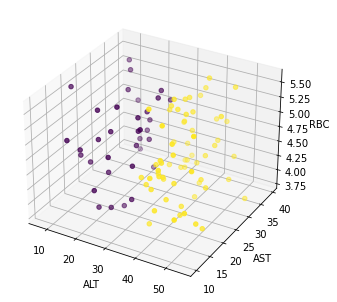

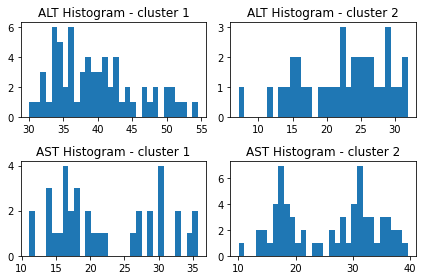

In [13]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Retrieve the ALT, AST and RBC column values from the dataset to cluster
variables2 = ["ALT","AST","RBC"]
EMR3d2 = sheet1.loc[:, variables2].values
CLUSTERS = 2

# Run the K-Means algorithm
# NOTICE, this time, we know that the correct number of clusters is 2
classifier = KMeans(CLUSTERS)
y_pred_KMeans2 = classifier.fit_predict(EMR3d2)

# Make a 3D chart
make_chart(EMR3d2, y_pred_KMeans2, variables2)

# print scores
print('silhouette score = ', silhouette_score(EMR3d2, y_pred_KMeans2, metric='euclidean'))
print('calinski_harabasz_score = ', calinski_harabasz_score(EMR3d2, y_pred_KMeans2))

# look at the data distribution across the clusters
cluster1 = EMR3d2[y_pred_KMeans2 == 0]
cluster2 = EMR3d2[y_pred_KMeans2 == 1]

fig,  ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2)

ax2.hist(cluster1[:,0], bins = 30)
ax2.set_title('ALT Histogram - cluster 2')

ax1.hist(cluster2[:,0], bins = 30)
ax1.set_title('ALT Histogram - cluster 1')

ax3.hist(cluster1[:,1], bins = 30)
ax3.set_title('AST Histogram - cluster 1')

ax4.hist(cluster2[:,1], bins = 30)
ax4.set_title('AST Histogram - cluster 2')

fig.tight_layout()
plt.show()


#### We can clearly see that the clusters are split around ALT value of around 30 

## Challenge 212
Scientists have found that in this population of patients, RBC distribution is uniform, ALT distribution is a Gaussian and AST distribution is a mixture of two Gaussians. Clearly, even by giving K-Means the correct K, the algorithm got to the wrong conclusion. This separation is "technically" correct, but lacks some underlying understanding of the natural phenomena.

#### What is the "problem" with this seperation?

The problem is that the clustering seems to be happening on the plane of ALT (where lower values of ALT belong to one cluster and higher values belong to the other cluster). KMeans is not taking into consideration the two gaussians of AST, which should be meaningful according to the domain knowledge.

The K-Means algorithm is not optimal for non-sphere clusters as it is distance-based and not distribution based hence will fail to idenify a gaussian cluster. We can see from the histograms above and plots below
that K-Means did a nice seperation but based on the first feature - ALT - which is actually one Gaussian and not by seperating the 2 Gaussians of AST.

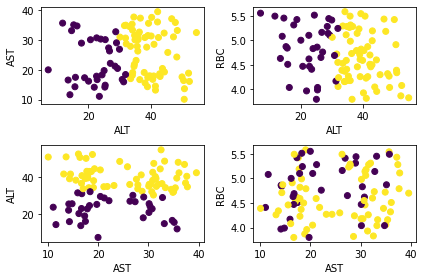

<Figure size 576x216 with 0 Axes>

In [14]:
fig,  ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2)
plt.figure(figsize=(8,3))

ax1.scatter(EMR3d2[:,0],EMR3d2[:,1],c=y_pred_KMeans2)
ax1.set_xlabel('ALT')
ax1.set_ylabel('AST')


ax2.scatter(EMR3d2[:,0],EMR3d2[:,2],c=y_pred_KMeans2)
ax2.set_xlabel('ALT')
ax2.set_ylabel('RBC')


ax3.scatter(EMR3d2[:,1],EMR3d2[:,0],c=y_pred_KMeans2)
ax3.set_xlabel('AST')
ax3.set_ylabel('ALT')

ax4.scatter(EMR3d2[:,1],EMR3d2[:,2],c=y_pred_KMeans2)
ax4.set_xlabel('AST')
ax4.set_ylabel('RBC')

fig.tight_layout()
plt.show()


In order to exploit the Gaussian characteristic of the AST
1. Find the 2 componenets that comprise the AST feature by applying the GMM algorith with the proper number of components.
2. Assume that the clusters above are correct for the entire dataset (including the other features).
3. Show the final clusters (of EMR3d2) in a 3D chart

[[33.784]]
[[[10.31697577]]]


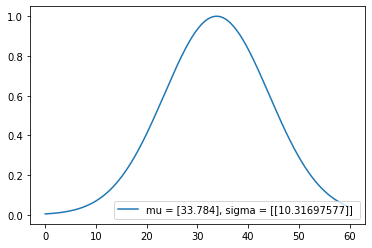

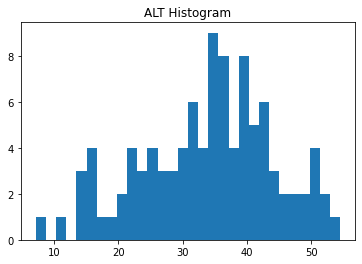

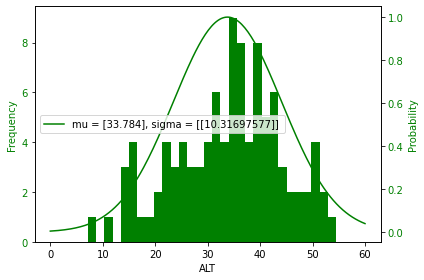

In [15]:
# let's look at the ALT Gaussian

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

from sklearn.mixture import GaussianMixture

variable_ALT = ["ALT"]
EMR3d3_ALT = sheet1.loc[:, variable_ALT].values
gmm_ALT = GaussianMixture(n_components=1, covariance_type='full')
y_pred_alt = gmm_ALT.fit_predict(EMR3d3_ALT)


print(gmm_ALT.means_)
print(np.sqrt(gmm_ALT.covariances_))

x_values = np.linspace(0, 60, 200)


mu =  gmm_ALT.means_[0]
sigma = np.sqrt(gmm_ALT.covariances_)[0]
y_values = gaussian(x_values, mu , sigma)
label = f'mu = { mu}, sigma = { sigma } '
plt.plot(x_values, y_values[0], label = label )
plt.legend()
plt.show()


plt.hist(EMR3d3_ALT, bins = 30)
plt.plot()
plt.title('ALT Histogram')
plt.show()


fig, ax1 = plt.subplots()

color = 'green'
ax1.set_xlabel('ALT')
ax1.set_ylabel('Frequency', color=color)
ax1.hist(EMR3d3_ALT, bins = 30, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'green'
ax2.set_ylabel('Probability', color=color)  # we already handled the x-label with ax1
ax2.plot(x_values, y_values[0], label = label, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()


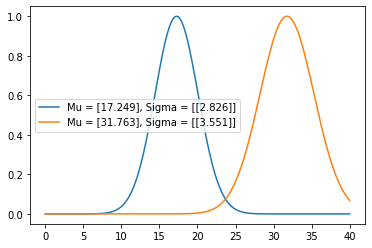

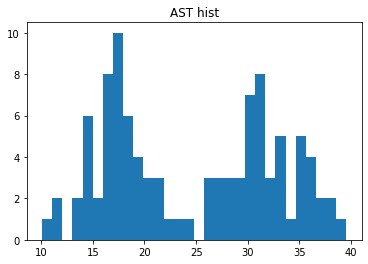

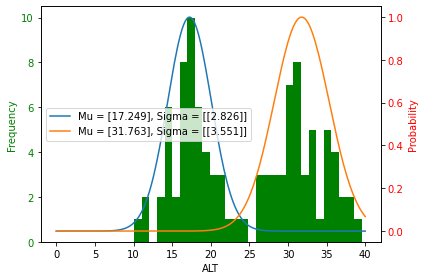

silhouette score =  0.34530854724950094
calinski_harabasz_score =  44.676816526193456

GMM clustering by AST applied to ALT, AST and RBC
----------------------------------------------------


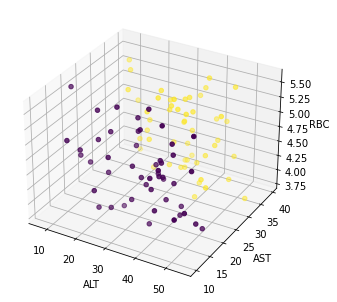

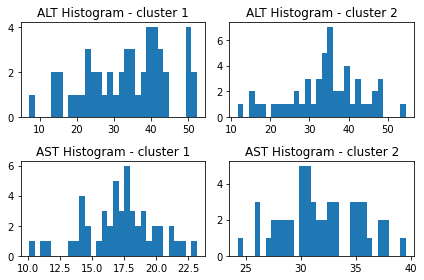

In [16]:
# let's look at the AST Gaussian

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

from sklearn.mixture import GaussianMixture

variable_AST = ["AST"]
EMR3d3_AST = sheet1.loc[:, variable_AST].values
gmm_AST = GaussianMixture(n_components=2).fit(EMR3d3_AST)
y_pred_ast = gmm_AST.predict(EMR3d3_AST)


# plot Gaussians

x_values = np.linspace(0, 40, 200)
for mu, sig in zip(gmm_AST.means_, np.sqrt(gmm_AST.covariances_)):
    y_values = gaussian(x_values, mu, sig)
    label = f'Mu = {np.round(mu,3)}, Sigma = {np.round(sig,3)}'
    plt.plot(x_values, y_values[0], label = label )
plt.legend()
plt.show()

# plot Data

plt.hist(EMR3d3_AST, bins = 30)
plt.title('AST hist')
plt.plot()
plt.show()

# plot Gaussians on the top of the data

fig, ax1 = plt.subplots()
color = 'green'
ax1.set_xlabel('ALT')
ax1.set_ylabel('Frequency', color=color)
ax1.hist(EMR3d3_AST, bins = 30, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Probability', color=color)  # we already handled the x-label with ax1
for mu, sig in zip(gmm_AST.means_, np.sqrt(gmm_AST.covariances_)):
    y_values = gaussian(x_values, mu, sig)
    label = f'Mu = {np.round(mu,3)}, Sigma = {np.round(sig,3)}'
    ax2.plot(x_values, y_values[0], label = label)
ax2.tick_params(axis='y', labelcolor=color)
plt.legend()


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()


print('silhouette score = ', silhouette_score(EMR3d2, y_pred_ast, metric='euclidean'))
print('calinski_harabasz_score = ', calinski_harabasz_score(EMR3d2, y_pred_ast))



# Make a 3D chart
print("\nGMM clustering by AST applied to ALT, AST and RBC")
print('----------------------------------------------------')
make_chart(EMR3d2, y_pred_ast, variables2)




# plot the histogram of values of ALT and AST in the different clusters

cluster1 = EMR3d2[y_pred_ast == 0]
cluster2 = EMR3d2[y_pred_ast == 1]

fig,  ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2)

ax1.hist(cluster1[:,0], bins = 30)
ax1.set_title('ALT Histogram - cluster 1')

ax2.hist(cluster2[:,0], bins = 30)
ax2.set_title('ALT Histogram - cluster 2')

ax3.hist(cluster1[:,1], bins = 30)
ax3.set_title('AST Histogram - cluster 1')

ax4.hist(cluster2[:,1], bins = 30)
ax4.set_title('AST Histogram - cluster 2')

fig.tight_layout()
plt.show()


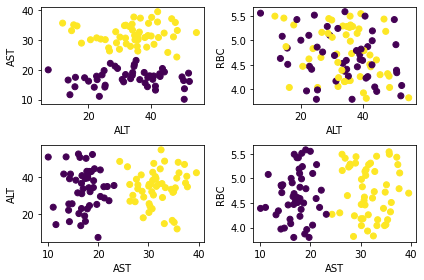

<Figure size 576x216 with 0 Axes>

In [17]:
# plot 2D scatter plot of the clustering
fig,  ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2)
plt.figure(figsize=(8,3))

ax1.scatter(EMR3d2[:,0],EMR3d2[:,1],c=y_pred_ast)
ax1.set_xlabel('ALT')
ax1.set_ylabel('AST')


ax2.scatter(EMR3d2[:,0],EMR3d2[:,2],c=y_pred_ast)
ax2.set_xlabel('ALT')
ax2.set_ylabel('RBC')


ax3.scatter(EMR3d2[:,1],EMR3d2[:,0],c=y_pred_ast)
ax3.set_xlabel('AST')
ax3.set_ylabel('ALT')

ax4.scatter(EMR3d2[:,1],EMR3d2[:,2],c=y_pred_ast)
ax4.set_xlabel('AST')
ax4.set_ylabel('RBC')

fig.tight_layout()
plt.show()




#### -> Here we can clearly see that the clusters are split on AST values (smaller and greater than 25, which is where the gaussians split)

#### What is the difference between the two clustering results above?

The Silhouette and CH score are similar between both clustering models, but the difference is the plane on which the clustering occurs. KMeans splits the clusteres based on ALT plane, and GMM, when run on AST (Based on Domain Knowledge), split the data on the AST plane (between the two gaussians) - clustering the data based on the AST gaussian distribution. 


#### Which one, given the domain knowledge provided to you, makes more sense?

If the domain knowledge indicates that the data should be split by AST alone, then the GMM makes more sense, as the data is split into two clusters, based on which AST distribution the data belongs to. However, if we need a combination of all three variables (ALT, AST, RBC) then KMeams make more sense as it uses all of them (though unable to take into consideration the two gaussians).




# Good Luck!

